In [96]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import pickle

In [97]:
df=pd.read_csv('../csv_data/modelling_ready_sales_data.csv')
df.head()

,id,price_per_unit,units_sold,total_revenue,year,month,weekday
0,1,50.5466,0,0.000,2023,1,6
1,2,52.1932,0,0.000,2023,1,0
2,3,49.0970,9,441.873,2023,1,1
3,4,52.6075,0,0.000,2023,1,2
4,5,50.1827,0,0.000,2023,1,3


In [117]:

models_dir = "../models/"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
numerical_features = ['price_per_unit', 'month']
X = df[numerical_features].values
y = df['units_sold'].values


scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_X_filename = os.path.join(models_dir, "scaler_X.pkl")
with open(scaler_X_filename, 'wb') as scaler_X_file:
    pickle.dump(scaler_X, scaler_X_file)


scaler_y = MinMaxScaler()
y = y.reshape(-1, 1)  
y_scaled = scaler_y.fit_transform(y)
scaler_y_filename = os.path.join(models_dir, "scaler_y.pkl")
with open(scaler_y_filename, 'wb') as scaler_y_file:
    pickle.dump(scaler_y, scaler_y_file)


y_scaled = y_scaled.ravel()

In [139]:
y_scaled


array([0.        , 0.        , 0.03501946, 0.        , 0.        ,
       0.08949416, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

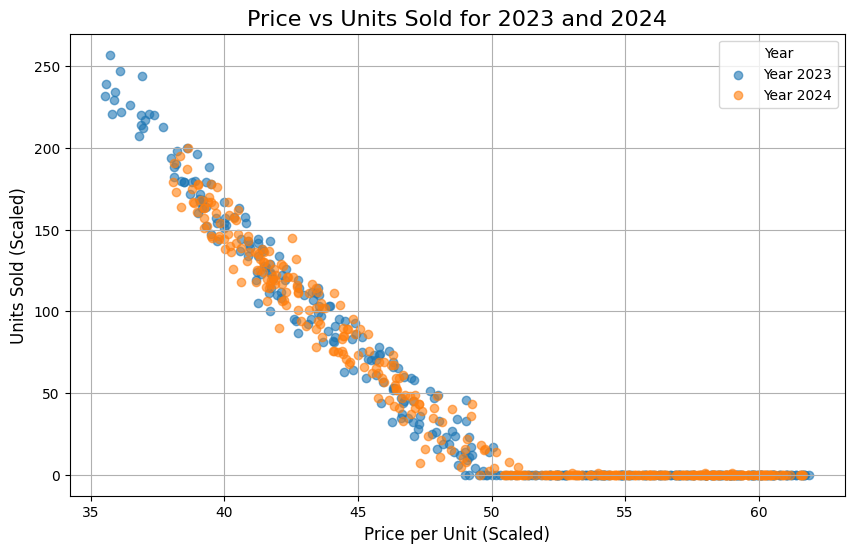

In [100]:

df_filtered = df[df['year'].isin([2023, 2024])]

plt.figure(figsize=(10, 6))
for year in [2023, 2024]:
    year_data = df_filtered[df_filtered['year'] == year]
    plt.scatter(year_data['price_per_unit'], year_data['units_sold'], label=f'Year {year}', alpha=0.6)
    
plt.title('Price vs Units Sold for 2023 and 2024', fontsize=16)
plt.xlabel('Price per Unit (Scaled)', fontsize=12)
plt.ylabel('Units Sold (Scaled)', fontsize=12)
plt.legend(title='Year')
plt.grid(True)

plt.show()


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              736 non-null    int64  
 1   price_per_unit  736 non-null    float64
 2   units_sold      736 non-null    int64  
 3   total_revenue   736 non-null    float64
 4   year            736 non-null    int64  
 5   month           736 non-null    int64  
 6   weekday         736 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 40.4 KB


**Negative Correlation:** The scatter plot clearly demonstrates a strong negative correlation between "Price per Unit" and "Units Sold" for both 2023 and 2024. As the price per unit increases, the number of units sold generally decreases, which aligns with the fundamental economic principle of demand and supply.

* **Year-over-Year Comparison:**
    * There appears to be some variation in the relationship between price and units sold across the two years. 
    * The data points for 2023 and 2024 seem to exhibit slightly different patterns. A more in-depth analysis, such as calculating separate correlation coefficients for each year, would be necessary to quantify these differences.

* **Potential Outliers:**
    * A few potential outliers are visible in the plot, which deviate significantly from the overall trend. These outliers could represent unusual events or anomalies that warrant further investigation.

## Parameters and models

In [102]:


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    
    'Support Vector Regression': SVR()
}

params = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.1, 1, 10, 100]},
    'Lasso Regression': {'alpha': [0.1, 1, 10, 100]},
    'Random Forest': {
        'n_estimators': [100, 200, 300],  
        'max_depth': [None, 10, 20, 30],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 4],    
        'max_features': ['sqrt', 'log2', None],  
        'bootstrap': [True, False]  
    },
    'Support Vector Regression': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}


## Grid Search Function

In [103]:
def tune_models(X_train, y_train):
    results = []

    for model_name, model in models.items():
        grid_search = GridSearchCV(estimator=model, param_grid=params[model_name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        results.append({
            'Model': model_name,
            'Best Parameters': best_params,
            'Best Score (MSE)': best_score
        })

    return pd.DataFrame(results)

## Train test Split

In [104]:
df.corr()

,id,price_per_unit,units_sold,total_revenue,year,month,weekday
id,1.000000,-0.373040,0.314854,0.336295,0.865997,0.491095,-0.005822
price_per_unit,-0.373040,1.000000,-0.906151,-0.919993,0.012253,-0.778625,0.011065
units_sold,0.314854,-0.906151,1.000000,0.996695,-0.032816,0.695074,-0.013415
total_revenue,0.336295,-0.919993,0.996695,1.000000,-0.022650,0.721073,-0.012314
year,0.865997,0.012253,-0.032816,-0.022650,1.000000,-0.002021,-0.008786
month,0.491095,-0.778625,0.695074,0.721073,-0.002021,1.000000,0.008810
weekday,-0.005822,0.011065,-0.013415,-0.012314,-0.008786,0.008810,1.000000


In [105]:
y

array([  0,   0,   9,   0,   0,  23,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  14,   4,   0,   0,  33,  46,   

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

tuned_res = tune_models(X_train, y_train)

print("Tuned Models and Their Best Parameters:")
print(tuned_res)

Tuned Models and Their Best Parameters:
                       Model  \
0          Linear Regression   
1           Ridge Regression   
2           Lasso Regression   
3              Random Forest   
4  Support Vector Regression   

                                     Best Parameters  Best Score (MSE)  
0                                                 {}         -0.011967  
1                                     {'alpha': 0.1}         -0.011967  
2                                     {'alpha': 0.1}         -0.067537  
3  {'bootstrap': True, 'max_depth': None, 'max_fe...         -0.001095  
4                         {'C': 10, 'kernel': 'rbf'}         -0.003006  


In [119]:
tuned_res

,Model,Best Parameters,Best Score (MSE)
0,Linear Regression,{},-0.011967
1,Ridge Regression,{'alpha': 0.1},-0.011967
2,Lasso Regression,{'alpha': 0.1},-0.067537
3,Random Forest,"{'bootstrap': True, 'max_depth': None, 'max_fe...",-0.001095
4,Support Vector Regression,"{'C': 10, 'kernel': 'rbf'}",-0.003006


## Training the Models with their best parameters

In [120]:

import numpy as np
import random
models_dir = "../models/"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
    
np.random.seed(42)
random.seed(42)    
model_performance = []

for model_name, model in models.items():
    best_params = tuned_res[tuned_res['Model'] == model_name]['Best Parameters'].values[0]
    model.set_params(**best_params)  


    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)


    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_cv_score = -np.mean(cv_scores)

    model_performance.append({
        'Model': model_name,
        'MSE': mse,
        'R2 Score': r2
    })
    model_filename = os.path.join(models_dir, f"{model_name.replace(' ', '_').lower()}_model.pkl")
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)

performance_df = pd.DataFrame(model_performance)
print("\nModel Performance on Test Data:")
performance_df



Model Performance on Test Data:


,Model,MSE,R2 Score
0,Linear Regression,0.012033,0.812647
1,Ridge Regression,0.012052,0.812352
2,Lasso Regression,0.064236,-0.000143
3,Random Forest,0.001105,0.982793
4,Support Vector Regression,0.003386,0.947286


In [109]:

print(f"Cross-Validation MSE Scores: {cv_scores}")
print(f"Mean Cross-Validation MSE: {cv_scores.mean()}")
print(f"Standard Deviation of MSE: {cv_scores.std()}")


Cross-Validation MSE Scores: [-261.03782791 -325.88793087 -303.85322294 -280.660175   -322.30204124]
Mean Cross-Validation MSE: -298.74823959191474
Standard Deviation of MSE: 24.76553451806328


In [138]:
def calculate_revenue(price, model, scaler):

        sample_input = np.array([[price, 5]])  
        sample_input_scaled = scaler.transform(sample_input) 
        predicted_units_sold = model.predict(sample_input_scaled)
        return price * predicted_units_sold


price_range = np.arange(20, 51, 0.1)  
optimal_price = None
max_revenue = 0

for price in price_range:
    revenue = calculate_revenue(price, model, scaler)
    if revenue > max_revenue:
        max_revenue = revenue
        optimal_price = price
optimal_price_input = np.array([[optimal_price, 5]]) 
optimal_price_scaled = scaler.transform(optimal_price_input)
predicted_optimal_units_sold = model.predict(optimal_price_scaled)[0]

predicted_optimal_units_sold = scaler_y.inverse_transform([[predicted_optimal_units_sold]])[0][0]

print(f"Model: {model_name}")
print(f"Optimal Price: {optimal_price:.2f}")  
print(f"Units Sold at Optimal Price: {predicted_optimal_units_sold:.2f}") 


Model: Support Vector Regression
Optimal Price: 37.30
Maximized Revenue: 22.76
Units Sold at Optimal Price: 156.82


e:\cv projects\Sales Insights\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
e:\cv projects\Sales Insights\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
e:\cv projects\Sales Insights\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
e:\cv projects\Sales Insights\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
e:\cv projects\Sales Insights\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
